# Aggregate CellRanger data and count viral reads

Stephen Fleming
20210204

## Start with one tissue at a time and explore the plots

In [1]:
# select tissue of interest

TISSUE = 'liver'

In [2]:
# !pip install harmony-pytorch

In [2]:
import pandas as pd
import numpy as np

import scanpy as sc
import harmony
from harmony import harmonize

import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sc.__version__

'1.6.1'

In [4]:
harmony.__version__

'0.1.3'

## Data

### Sample information

In [6]:
# concatenate sample sheets

d = []

import glob

for file in glob.glob('/home/jupyter-user/analysis/sampletracking_*tissue.csv'):
    d.append(pd.read_csv(file))

data = pd.concat(d)

`data` now contains the sample sheet table... the most important part just being a column called `"tissue"` which tells us which tissue each sample comes from.

In [10]:
len(data[data['tissue'] == TISSUE])

17

### Aggregate data

In [13]:
# these were QC failures (ignored here in case the files are still present in the data table)

EXCLUDE_SAMPLES = ['02-P166169-S092-R01', '02-P166169-S087-R02', 
                   '04-P103142-S039-R01', '04-P079042-S047-R01', 
                   '04-P054921-S064-R01']

In [20]:
samples = (data[(data['tissue'] == TISSUE) 
                & data['sampleid'].apply(lambda s: 
                                         s not in EXCLUDE_SAMPLES)]['sampleid'].tolist()
           + df_tissues[(df_tissues['tissue'] == TISSUE)
                        & df_tissues['entity:sample_id'].apply(lambda s: 
                                                               s not in EXCLUDE_SAMPLES)]\
           ['entity:sample_id'].tolist())
samples

['02-P166169-S109-R01',
 '02-P248880-S041-R01',
 '02-P005175-S022-R01',
 '02-P118946-S070-R01',
 '02-P166169-S022-R01',
 '02-P240970-S016-R01',
 '02-P334354-S041-R01',
 '02-P348762-S041-R01',
 '04-P054921-S080-R01',
 '04-P079042-S079-R01',
 '04-P103142-S069-R01',
 '12-P485759-S020-R01',
 '12-P230638-S003-R01',
 '12-P617758-S003-R01',
 '12-P852049-S003-R01',
 '12-P890292-S003-R01']

In [15]:
from typing import List
import anndata
import gc


def aggregate_cellranger_data(sample_list: List[str],
                              n_umi_cutoff: int = 0,
                              n_gene_cutoff: int = 0,
                              directory: str = '/home/jupyter-user/data/cellranger/') -> anndata.AnnData:
    """Aggregate several CellRanger h5 files into one anndata object."""
    
    adata_list = []
    
    for sample in sample_list:
        
        print(sample)
        
        # find file
        filename = glob.glob(os.path.join(directory, sample + '*.h5'))
        
        if len(filename) == 0:
            print(f'Skipping sample {sample}... it is assumed it failed QC.')
            continue
        
        assert len(filename) == 1, f'file glob was {filename}'
        filename = filename[0]
        
        # load data
        ad_tmp = sc.read_10x_h5(filename)
        ad_tmp.var_names_make_unique()
        ad_tmp.obs['sample'] = sample
        ad_tmp.obs.index = sample + ad_tmp.obs.index
        
        # filter cells
        sc.pp.filter_cells(ad_tmp, 
                           min_counts=n_umi_cutoff, 
                           inplace=True)
        sc.pp.filter_cells(ad_tmp,  
                           min_genes=n_gene_cutoff, 
                           inplace=True)
        print(ad_tmp.shape)
        adata_list.append(ad_tmp)
        
        # clean up
        del ad_tmp
        gc.collect()
        
    # concatenate into a big object
    adata = adata_list[0].concatenate(*adata_list[1:], join='outer')
    return adata


def aggregate_data(sample_list: List[str],
                   directory: str = '/home/jupyter-user/analysis/pegasus') -> anndata.AnnData:
    """Aggregate several h5ad files into one anndata object."""
    
    adata_list = []
    
    for sample in sample_list:
        
        print(sample)
        
        # find file
        filename = glob.glob(os.path.join(directory, sample + '*.h5ad'))
        
        if len(filename) == 0:
            print(f'Skipping sample {sample}... it is assumed it failed QC.')
            continue
        
        assert len(filename) == 1, f'file glob was {filename}'
        filename = filename[0]
        
        # load data
        ad_tmp = sc.read_h5ad(filename)
        print(ad_tmp.shape)
        adata_list.append(ad_tmp)
        
        # clean up
        del ad_tmp
        gc.collect()
        
    # concatenate into a big object
    adata = adata_list[0].concatenate(*adata_list[1:], join='outer')
    return adata

In [22]:
adata = aggregate_cellranger_data(samples,
                                  n_umi_cutoff=1, n_gene_cutoff=0)

02-P166169-S109-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(119027, 33567)
02-P248880-S041-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(602550, 33567)
02-P005175-S022-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(1324209, 33567)
02-P118946-S070-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(506484, 33567)
02-P166169-S022-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(627134, 33567)
02-P240970-S016-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(465770, 33567)
02-P334354-S041-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(703128, 33567)
02-P348762-S041-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(929972, 33567)
04-P054921-S080-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(909163, 33567)
04-P079042-S079-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(1186736, 33567)
04-P103142-S069-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(629232, 33567)
12-P485759-S020-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(904522, 33567)
12-P230638-S003-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(1054693, 33567)
12-P617758-S003-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(1336119, 33567)
12-P852049-S003-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(1242698, 33567)
12-P890292-S003-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(1198013, 33567)


In [23]:
adata

AnnData object with n_obs × n_vars = 13739450 × 33567
    obs: 'sample', 'n_counts', 'n_genes', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [24]:
adata.var['genome'].unique()

array(['GRCh38premrna', 'SARSCoV2'], dtype=object)

In [25]:
sars_genes = adata.var_names[adata.var['genome'] == 'SARSCoV2']
sars_genes

Index(['SARSCoV2______SARSCoV2_5prime', 'SARSCoV2______SARSCoV2_nsp1',
       'SARSCoV2______SARSCoV2_nsp2', 'SARSCoV2______SARSCoV2_nsp3',
       'SARSCoV2______SARSCoV2_nsp4', 'SARSCoV2______SARSCoV2_nsp5',
       'SARSCoV2______SARSCoV2_nsp6', 'SARSCoV2______SARSCoV2_nsp7',
       'SARSCoV2______SARSCoV2_nsp8', 'SARSCoV2______SARSCoV2_nsp9',
       'SARSCoV2______SARSCoV2_nsp10', 'SARSCoV2______SARSCoV2_nsp11',
       'SARSCoV2______SARSCoV2_nsp12', 'SARSCoV2______SARSCoV2_nsp13',
       'SARSCoV2______SARSCoV2_nsp14', 'SARSCoV2______SARSCoV2_nsp15',
       'SARSCoV2______SARSCoV2_nsp16', 'SARSCoV2______SARSCoV2_S',
       'SARSCoV2______SARSCoV2_ORF3a', 'SARSCoV2______SARSCoV2_E',
       'SARSCoV2______SARSCoV2_M', 'SARSCoV2______SARSCoV2_ORF6',
       'SARSCoV2______SARSCoV2_ORF7a', 'SARSCoV2______SARSCoV2_ORF7b',
       'SARSCoV2______SARSCoV2_ORF8', 'SARSCoV2______SARSCoV2_N',
       'SARSCoV2______SARSCoV2_ORF10', 'SARSCoV2______SARSCoV2_3prime',
       'SARSCoV2______SARSCoV2_

In [26]:
len(sars_genes)

29

Two counting strategies, just as a double-check.

In [27]:
adata.X[:, np.array([g in sars_genes for g in adata.var_names])].sum()

45.0

In [28]:
adata.X[:, adata.var_names.str.startswith('SARSCoV2_')].sum()

45.0

## Number of viral droplets as a function of UMI cutoff

In [29]:
adata.obs['viral_reads'] = \
    np.array(adata.X[:, adata.var_names.str.startswith('SARSCoV2_')].sum(axis=1)).squeeze()

In [30]:
adata

AnnData object with n_obs × n_vars = 13739450 × 33567
    obs: 'sample', 'n_counts', 'n_genes', 'batch', 'viral_reads'
    var: 'gene_ids', 'feature_types', 'genome'

In [31]:
plt.rcParams.update({'font.size': 12})

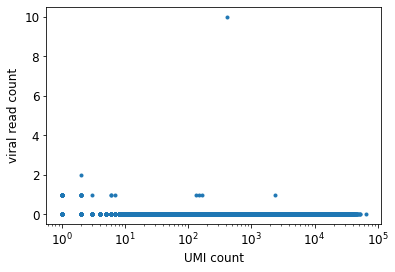

In [32]:
plt.plot(adata.obs['n_counts'], adata.obs['viral_reads'], '.')
plt.xscale('log')
plt.ylabel('viral read count')
plt.xlabel('UMI count')
plt.show()

In [33]:
order = np.argsort(adata.obs['n_counts'])
cumsum_reads = np.cumsum(adata.obs['viral_reads'][order].values)
cumsum_drops = np.cumsum(np.minimum(1, adata.obs['viral_reads'][order].values))

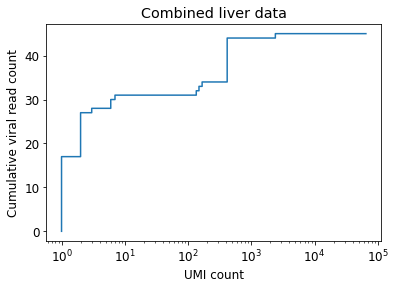

In [34]:
plt.plot(adata.obs['n_counts'][order].values, cumsum_reads)
plt.xscale('log')
plt.xlabel('UMI count')
plt.ylabel('Cumulative viral read count')
plt.title(f'Combined {TISSUE} data')

plt.gcf().savefig(f'virus_{TISSUE}_cumulative_reads.pdf', bbox_inches='tight')

plt.show()

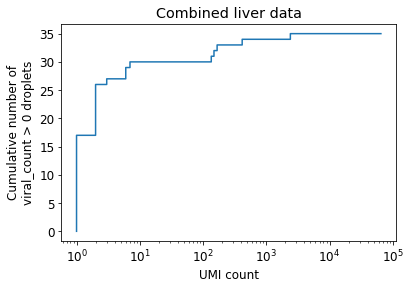

In [35]:
plt.plot(adata.obs['n_counts'][order].values, cumsum_drops)
plt.xscale('log')
plt.xlabel('UMI count')
plt.ylabel('Cumulative number of\nviral_count > 0 droplets')
plt.title(f'Combined {TISSUE} data')

plt.gcf().savefig(f'virus_{TISSUE}_cumulative_positive_droplets.pdf', bbox_inches='tight')

plt.show()

## CDF of viral droplets as a function of UMI cutoff

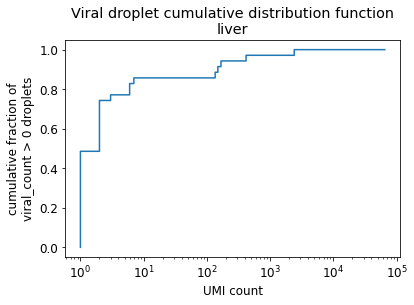

In [36]:
plt.plot(adata.obs['n_counts'][order].values, cumsum_drops / cumsum_drops[-1])
plt.xscale('log')
plt.xlabel('UMI count')
plt.ylabel('cumulative fraction of\nviral_count > 0 droplets')
plt.title('Viral droplet cumulative distribution function\n' + TISSUE)
plt.show()

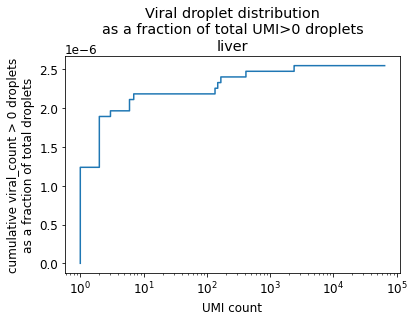

In [37]:
plt.plot(adata.obs['n_counts'][order].values, cumsum_drops / adata.shape[0])
plt.xscale('log')
plt.xlabel('UMI count')
plt.ylabel('cumulative viral_count > 0 droplets\nas a fraction of total droplets')
plt.title('Viral droplet distribution\nas a fraction of total UMI>0 droplets\n' + TISSUE)
plt.show()

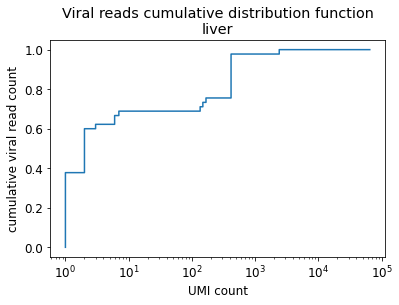

In [38]:
plt.plot(adata.obs['n_counts'][order].values, cumsum_reads / cumsum_reads[-1])
plt.xscale('log')
plt.xlabel('UMI count')
plt.ylabel('cumulative viral read count')
plt.title('Viral reads cumulative distribution function\n' + TISSUE)
plt.show()

## Viral reads overlaid on UMI curve

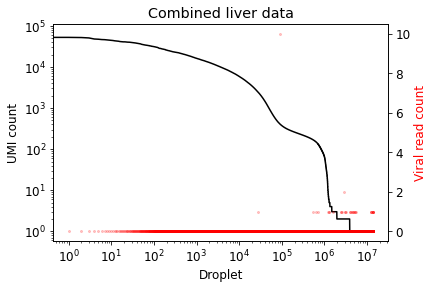

In [39]:
plt.semilogy(adata.obs['n_counts'].values[order[::-1]], 
             'k-', rasterized=True,
             label='UMI curve')
plt.xscale('log')
plt.xlabel('Droplet')
plt.ylabel('UMI count')
plt.twinx()
plt.plot(adata.obs['viral_reads'].values[order[::-1]], 
         '.', ms=4, alpha=0.2, color='red', rasterized=True,
         label='Viral reads')
if TISSUE == 'lung':
    plt.yscale('log')
plt.ylabel('Viral read count', color='red')
# plt.legend()
plt.title(f'Combined {TISSUE} data')

plt.gcf().savefig(f'virus_{TISSUE}_UMI_curve.pdf', bbox_inches='tight')

plt.show()

## Whole hog in one panel

Run the above for all tissues, and plot them all together.

In [ ]:
d = {}

for TISSUE in ['liver', 'kidney', 'heart', 'lung']:
    
    print(TISSUE)
    
    samples = (data[(data['tissue'] == TISSUE) 
                    & data['sampleid'].apply(lambda s: 
                                             s not in EXCLUDE_SAMPLES)]['sampleid'].tolist()
               + df_tissues[(df_tissues['tissue'] == TISSUE)
                            & df_tissues['entity:sample_id'].apply(lambda s: 
                                                                   s not in EXCLUDE_SAMPLES)]\
               ['entity:sample_id'].tolist())
    
    print('   ', len(samples), 'samples')
    
    print('    loading...')
    adata = aggregate_cellranger_data(samples,
                                      n_umi_cutoff=1, n_gene_cutoff=0)
    
    print('    counting viral reads...')
    
    adata.obs['viral_reads'] = \
        np.array(adata.X[:, adata.var_names.str.startswith('SARSCoV2_')].sum(axis=1)).squeeze()
    
    order = np.argsort(adata.obs['n_counts'])
    cumsum_reads = np.cumsum(adata.obs['viral_reads'][order].values)
    cumsum_drops = np.cumsum(np.minimum(1, adata.obs['viral_reads'][order].values))
    
    d.update({TISSUE + '_x': adata.obs['n_counts'][order].values,
              TISSUE + '_frac': cumsum_drops / adata.shape[0],
              TISSUE + '_reads': cumsum_reads, 
              TISSUE + '_cum': cumsum_drops / cumsum_drops[-1],})

In [22]:
d

{'liver_x': array([1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 5.2222e+04, 5.2670e+04,
        6.4963e+04], dtype=float32),
 'liver_frac': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.5474091e-06,
        2.5474091e-06, 2.5474091e-06]),
 'liver_reads': array([ 0.,  0.,  0., ..., 45., 45., 45.], dtype=float32),
 'liver_cum': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'kidney_x': array([1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 3.8800e+04, 4.3299e+04,
        8.0469e+04], dtype=float32),
 'kidney_frac': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.09001495e-06, 2.09001495e-06, 2.09001495e-06]),
 'kidney_reads': array([ 0.,  0.,  0., ..., 24., 24., 24.], dtype=float32),
 'kidney_cum': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'heart_x': array([1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 7.7635e+04, 7.7932e+04,
        8.0328e+04], dtype=float32),
 'heart_frac': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.9659

In [23]:
np.save('/home/jupyter-user/analysis/viral_summary.npy', d)

In [ ]:
# d = np.load('/home/jupyter-user/analysis/viral_summary.npy', allow_pickle=True).item()

In [32]:
import gc
gc.collect()

9141

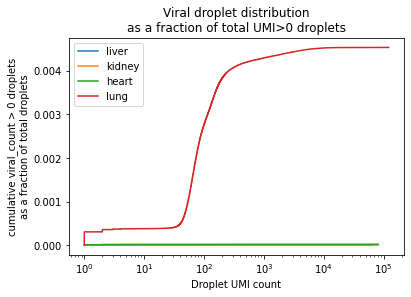

In [30]:
for TISSUE in ['liver', 'kidney', 'heart', 'lung']:
    plt.plot(d[TISSUE + '_x'], d[TISSUE + '_frac'], label=TISSUE, rasterized=True)
    
plt.xscale('log')
plt.xlabel('Droplet UMI count')
plt.ylabel('cumulative viral_count > 0 droplets\nas a fraction of total droplets')
plt.title('Viral droplet distribution\nas a fraction of total UMI>0 droplets')
plt.legend()



plt.show()

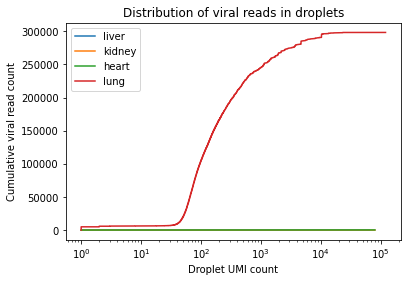

In [29]:
for TISSUE in ['liver', 'kidney', 'heart', 'lung']:
    plt.plot(d[TISSUE + '_x'], d[TISSUE + '_reads'], label=TISSUE, rasterized=True)

plt.xscale('log')
plt.xlabel('Droplet UMI count')
plt.ylabel('Cumulative viral read count')
plt.title('Distribution of viral reads in droplets')
plt.legend()

# plt.gcf().savefig(f'virus_{TISSUE}_cumulative_reads.pdf', bbox_inches='tight')

plt.show()

## Extended Data Figure 11l

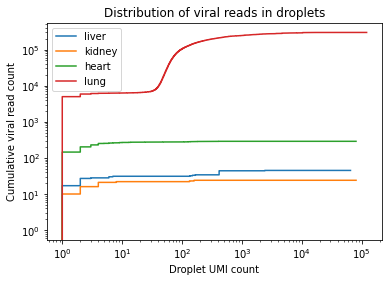

In [36]:
for TISSUE in ['liver', 'kidney', 'heart', 'lung']:
    plt.plot(d[TISSUE + '_x'], d[TISSUE + '_reads'], label=TISSUE)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet UMI count')
plt.ylabel('Cumulative viral read count')
plt.title('Distribution of viral reads in droplets')
plt.legend()

plt.gcf().savefig(f'virus_cumulative_reads_onepanel_summary.pdf', bbox_inches='tight')

plt.show()

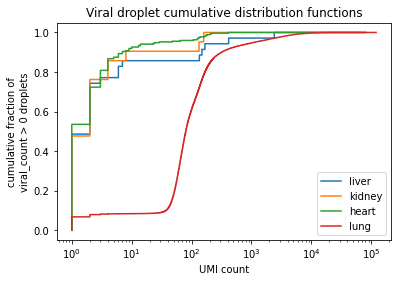

In [31]:
for TISSUE in ['liver', 'kidney', 'heart', 'lung']:
    plt.plot(d[TISSUE + '_x'], d[TISSUE + '_cum'], label=TISSUE, rasterized=True)

plt.xscale('log')
plt.xlabel('UMI count')
plt.ylabel('cumulative fraction of\nviral_count > 0 droplets')
plt.title('Viral droplet cumulative distribution functions')
plt.legend()


plt.show()